In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [0]:
#tf.compat.v1.enable_eager_execution()

In [0]:

class HMM:

  def __init__(self, M):
    self.M = M

  def set_session(self, session):
    self.session = session

  def fit(self, X, max_iter=10, print_period=1):
    N = len(X)
    print("Number of train samples: ", N)
    costs = []
    for it in range(max_iter):
      if it%print_period == 0:
        print("it: ", it)
      for n in range(N):
        c = self.get_cost_multi(X).sum()
        costs.append(c)
        self.session.run(self.train_op, feed_dict={self.tfx: X[n]})

    plt.plot(costs)
    plt.show()

  def get_cost(self, x):
    return self.session.run(self.cost, feed_dict={self.tfx: x})

  def get_cost_multi(self, X):
    return np.array([self.get_cost(x) for x in X])

  def log_likelihood(self, x):
    return -self.session.run(self.cost, feed_dict={self.tfx: x})

  def build(self, preSoftmaxPi, preSoftmaxA, preSoftmaxB):
    M, V = preSoftmaxB.shape
    self.preSoftmaxPi = tf.Variable(preSoftmaxPi)
    self.preSoftmaxA = tf.Variable(preSoftmaxA)
    self.preSoftmaxB = tf.Variable(preSoftmaxB)
    pi = tf.nn.softmax(self.preSoftmaxPi)
    A = tf.nn.softmax(self.preSoftmaxA)
    B = tf.nn.softmax(self.preSoftmaxB)
    self.tfx = tf.placeholder(tf.int32, shape=(None,), name='x')
    def recurrence(old_a_old_s, x_t):
      old_a = tf.reshape(old_a_old_s[0], (1,M))
      a = tf.matmul(old_a, A) * B[:, x_t]
      a = tf.reshape(a, (M,))
      s = tf.reduce_sum(a)
      return (a/s), s
    alpha, scale = tf.scan(
        fn=recurrence,
        elems=self.tfx[1:],
        initializer=(pi*B[:,self.tfx[0]], np.float32(1.0)),
    )
    self.cost = -tf.reduce_sum(tf.log(scale))
    self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)

  def init_random(self, V):
    preSoftmaxPi0 = np.zeros(self.M).astype(np.float32)
    preSoftmaxA0 = np.random.randn(self.M, self.M).astype(np.float32)
    preSoftmaxB0 = np.random.randn(self.M, V).astype(np.float32)
    self.build(preSoftmaxPi0, preSoftmaxA0, preSoftmaxB0)

  def set(self, preSoftmaxPi, preSoftmaxA, preSoftmaxB):
    op1 = self.preSoftmaxPi.assign(preSoftmaxPi)
    op2 = self.preSoftmaxA.assign(preSoftmaxA)
    op3 = self.preSoftmaxB.assign(preSoftmaxB)
    self.session.run([op1, op2, op3])

In [0]:
def fit_coin():
  X = []
  for line in open("coin_data.txt"):
    x = [1 if e == 'H' else 0 for e in line.rstrip()]
    X.append(x)
  hmm = HMM(2)
  hmm.init_random(2)
  init = tf.global_variables_initializer()
  with tf.Session() as session:
    session.run(init)
    hmm.set_session(session)
    hmm.fit(X, max_iter=5)
    L = hmm.get_cost_multi(X).sum()
    print("LL with fitted params: ", L)
    pi = np.log(np.array([0.5, 0.5])).astype(np.float32)
    A = np.log(np.array([[0.1, 0.9], [0.8, 0.2]])).astype(np.float32)
    B = np.log(np.array([[0.6, 0.4], [0.3, 0.7]])).astype(np.float32)
    hmm.set(pi, A, B)
    L = hmm.get_cost_multi(X).sum()
    print("LL with true params: ", L)

Number of train samples:  50
it:  0
it:  1
it:  2
it:  3
it:  4


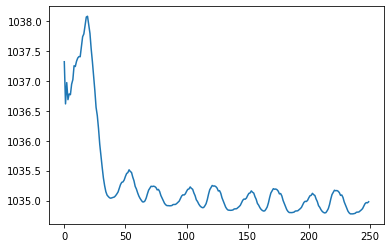

LL with fitted params:  1035.0219
LL with true params:  1059.7229


In [5]:
fit_coin()